### **Connecting Notebook to our Google Drive**

In [1]:
from google.colab import drive
 
gdrive = drive.mount('/gdrive')

#Project Folder
%cd /gdrive/'My Drive'/object_detection

# When prompted:
#   Go to the Link provided
#   Login to the Google account having the object_detection folder
#   Accept the Permissions of Google Drive File Stream
#   Enter your authorization code

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/object_detection


### **Seperating Annotations for Training and Testing Data**

In [0]:
#Two dir for training and testing
!mkdir test_labels train_labels

# Lists the files inside 'annotations' by their hash value instead
# Then, moves the first 40 labels to the testing dir: `test_labels`
!ls data/annotations/* | sort -R | head -40 | xargs -I{} mv {} test_labels/
print("test_labels directory created and labels moved")
print()

# Moves the rest of 45 labels to the training dir: `train_labels`
!ls data/annotations/* | xargs -I{} mv {} train_labels/
print("train_labels directory created and labels moved")

mkdir: cannot create directory ‘test_labels’: File exists
mkdir: cannot create directory ‘train_labels’: File exists
ls: cannot access 'data/annotations/*': No such file or directory
test_labels directory created and labels moved

ls: cannot access 'data/annotations/*': No such file or directory
train_labels directory created and labels moved


### **Importing and Installing Required Packages**

In [2]:
# Required Packages that are not installed in Collab
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib
!pip install -q pycocotools

# Required Libraries
from __future__ import division, print_function, absolute_import

import pandas as pd

# Numpy 1.18.0 breaks the evaluation process for both TensorFlow 
# and PyTorch object detection
#   NOTE: You must restart the runtime in order to use newly installed versions.

!pip install numpy==1.16.2
import numpy as np
print("Numpy Version is " +  np.__version__)

import csv

import re
import os
import io
import glob
import shutil
import urllib.request
import tarfile
import xml.etree.ElementTree as ET

# To make sure tf version used is 1.15.2
%tensorflow_version 1.x
import tensorflow as tf
print("TensorFlow Version is " +  tf.__version__)

import cv2 

from PIL import Image
from collections import namedtuple, OrderedDict

from google.colab import files

Numpy Version is 1.16.2
TensorFlow 1.x selected.
TensorFlow Version is 1.15.2


### **Converts XML files to CSV**

In [0]:
'''
Also creates a pbtxt file that will contain the label map for each class. 
pbtxt file will tell the model what each object is by defining a mapping 
of class names to class ID numbers.

Current directory: object_detection/data/
Images format: jpg
'''

def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)

Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.


In [0]:
# The pbtxt file
!cat label_map.pbtxt

item {
    id: 1
    name: 'Waldo'
}

### **Tensorflow Model Setup**

In [0]:
# Downloads the models
!git clone --q https://github.com/tensorflow/models.git

In [3]:
!pwd

%cd models/research/

# compile the proto buffers - https://developers.google.com/protocol-buffers/
!protoc object_detection/protos/*.proto --python_out=.

# export PYTHONPATH environment var with research and slim paths
os.environ['PYTHONPATH'] += ':./:./slim/'

/gdrive/My Drive/object_detection
/gdrive/My Drive/object_detection/models/research


In [0]:
# Checking to see if everything is installed properly
!python3 object_detection/builders/model_builder_test.py

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_wi

### Generating Tf record


In [0]:
'''
Tensorflow accepts the data as tfrecords which is a binary file 
that run fast with low memory usage.

converts the csv files for training and testing data to two TFRecords files 
and places the output in the same directory as the input

'''
!pwd

from object_detection.utils import dataset_util

# This may change
DATA_BASE_PATH = '/gdrive/My Drive/object_detection/'
image_dir = DATA_BASE_PATH +'data/images/'

def class_text_to_int(row_label):
		if row_label == 'Waldo':  # Change this based on pbtxt file
				return 1
		else:
			  None


def split(df, group):
		data = namedtuple('data', ['filename', 'object'])
		gb = df.groupby(group)
		return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
		with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
				encoded_jpg = fid.read()
		encoded_jpg_io = io.BytesIO(encoded_jpg)
		image = Image.open(encoded_jpg_io)
		width, height = image.size


		filename = group.filename.encode('utf8')
		image_format = b'jpg'
		xmins = []
		xmaxs = []
		ymins = []
		ymaxs = []
		classes_text = []
		classes = []

		for index, row in group.object.iterrows():
				xmins.append(row['xmin'] / width)
				xmaxs.append(row['xmax'] / width)
				ymins.append(row['ymin'] / height)
				ymaxs.append(row['ymax'] / height)
				classes_text.append(row['class'].encode('utf8'))
				classes.append(class_text_to_int(row['class']))

		tf_example = tf.train.Example(features=tf.train.Features(feature={
				'image/height': dataset_util.int64_feature(height),
				'image/width': dataset_util.int64_feature(width),
				'image/filename': dataset_util.bytes_feature(filename),
				'image/source_id': dataset_util.bytes_feature(filename),
				'image/encoded': dataset_util.bytes_feature(encoded_jpg),
				'image/format': dataset_util.bytes_feature(image_format),
				'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
				'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
				'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
				'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
				'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
				'image/object/class/label': dataset_util.int64_list_feature(classes),
		}))
		return tf_example

for csv in ['train_labels', 'test_labels']:
  writer = tf.io.TFRecordWriter(DATA_BASE_PATH + csv + '.record')
  path = os.path.join(image_dir)
  examples = pd.read_csv(DATA_BASE_PATH + csv + '.csv')
  grouped = split(examples, 'filename')
  for group in grouped:
      tf_example = create_tf_example(group, path)
      writer.write(tf_example.SerializeToString())
    
  writer.close()
  output_path = os.path.join(os.getcwd(), DATA_BASE_PATH + csv + '.record')
  print('Successfully created the TFRecords: {}'.format(DATA_BASE_PATH +csv + '.record'))



/gdrive/My Drive/object_detection/models/research
Successfully created the TFRecords: /gdrive/My Drive/object_detection/train_labels.record
Successfully created the TFRecords: /gdrive/My Drive/object_detection/test_labels.record


In [0]:
# Setting the paths for the records as well as pbtx for easier access later.
train_record_fname = '/gdrive/My Drive/object_detection/train_labels.record'
test_record_fname = '/gdrive/My Drive/object_detection/test_labels.record'
label_map_pbtxt_fname = '/gdrive/My Drive/object_detection/label_map.pbtxt'

### Downloading the Base Model

In [0]:
%cd /gdrive/My Drive/object_detection/models/research

# Some models to train on ### ssd_mobilenet_v2_coco_2018_03_29
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
    },
}


# Select a model from `MODELS_CONFIG`.
# Chosen ssd_mobilenet_v2 for this project, you could choose any
selected_model = 'ssd_mobilenet_v2'

#the distination folder where the model will be saved
#change this if you have a different working dir
DEST_DIR = '/gdrive/My Drive/object_detection/models/research/pretrained_model'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

#selecting the model
MODEL_FILE = MODEL + '.tar.gz'

#creating the downlaod link for the model selected
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#checks if the model has already been downloaded, download it otherwise
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#unzipping the model and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# creating an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/gdrive/My Drive/object_detection/models/research


### Configuring the Training Pipeline

In [0]:
#path to the config file for our model
!cat object_detection/samples/configs/ssd_mobilenet_v2_coco.config

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 90
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect

### Edit Config File 



In [0]:
# path to the config file
%%writefile object_detection/samples/configs/ssd_mobilenet_v2_coco.config

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1 # number of classes to be detected
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    image_resizer { # all images will be resized to the below W x H.
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: true # to counter over fitting. you can also try tweaking its probability below
        dropout_keep_probability: 0.8
        kernel_size: 1
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer { # higher regularizition to counter overfitting
              weight: 0.0001
            }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
          batch_norm {
            train: true,
            scale: true,
            center: true,
            decay: 0.9997,
            epsilon: 0.001,
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_mobilenet_v2'
      min_depth: 16
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            weight: 0.001
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000
        iou_threshold: 0.99
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 3
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 24
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.004
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }
  fine_tune_checkpoint: "/gdrive/My Drive/object_detection/models/research/pretrained_model/model.ckpt"
  fine_tune_checkpoint_type:  "detection"
  from_detection_checkpoint: true
  load_all_detection_checkpoint_vars: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  # We are using only 200000 due to the time it takes for a 100 step (123 seconds)
  num_steps: 200000
  data_augmentation_options { ## https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }

  data_augmentation_options {
    random_rotation90 {
    }
  }
  data_augmentation_options {
    random_patch_gaussian {
    }
  }
  data_augmentation_options {
    random_jitter_boxes {
    }
  }
  data_augmentation_options {
    random_pixel_value_scale {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "/gdrive/My Drive/object_detection/train_labels.record"
  }
  label_map_path: "/gdrive/My Drive/object_detection/label_map.pbtxt"
}

eval_config: {
  num_examples: 2000
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  max_evals: 15
  num_visualizations: 45 # the number of visualization to see in tensorboard
  min_score_threshold: 0.2
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/gdrive/My Drive/object_detection/test_labels.record"
  }
  label_map_path: "/gdrive/My Drive/object_detection/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}

Overwriting object_detection/samples/configs/ssd_mobilenet_v2_coco.config


In [0]:
# Checking the config file after editing 
!cat object_detection/samples/configs/ssd_mobilenet_v2_coco.config


# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1 # number of classes to be detected
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
      

### Tensorboard

In [5]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-05-26 12:31:18--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.20.123.149, 52.54.124.219, 34.233.91.203, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.20.123.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.6’

ngrok-stable-linux- 100%[===================>]  13.13M  13.1MB/s    in 1.0s    

2020-05-26 12:31:20 (13.1 MB/s) - ‘ngrok-stable-linux-amd64.zip.6’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [6]:
# If Error comes up, retry until you get a link

#the logs that are created while training 
LOG_DIR = "training/"
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
#The link to tensorboard.
#works after the training starts.
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# Running this code shows the url where u can access Tensorboard

https://3725e565.ngrok.io


### Training

In [0]:
!python3 object_detection/model_main.py \
    --pipeline_config_path=/gdrive/My\ Drive/object_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --model_dir=training/

Streaming output truncated to the last 5000 lines.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0525 22:42:49.398116 139693129197440 convolutional_box_predictor.py:151] depth of additional conv before box predictor: 0
INFO:tensorflow:Done calling model_fn.
I0525 22:42:50.941071 139693129197440 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-05-25T22:42:50Z
I0525 22:42:50.956828 139693129197440 evaluation.py:255] Starting evaluation at 2020-05-25T22:42:50Z
INFO:tensorflow:Graph was finalized.
I0525 22:42:51.376801 139693129197440 monitored_session.py:240] Graph was finalized.
2020-05-25 22:42:51.377493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-25 22:42:51.377878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla P4 major:

### Export the Final Model

In [7]:
#the location where the exported model will be saved in.
output_directory = './fine_tuned_model'

# goes through the model is the training/ dir and gets the last one.
# you could choose a specfic one instead of the last
lst = os.listdir('training')
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')


last_model_path = os.path.join('training', last_model)

#exports the model specifed and inference graph
!python /gdrive/'My Drive'/object_detection/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/gdrive/My\ Drive/object_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0526 12:33:21.338234 140065614575488 module_wrapper.py:139] From /gdrive/My Drive/object_detection/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0526 12:33:22.944417 140065614575488 module_wrapper.py:139] From /gdrive/My Drive/object_detection/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0526 12:33:22.947409 140065614575488 module_wrapper.py:139] From /gdrive/My Drive/object_detection/models/research/object_detection/exporter.py:121: The na

### Download the Model (for use)

In [0]:
# Downloads the frozen model that is needed for inference
files.download(output_directory + '/frozen_inference_graph.pb')

In [0]:
DATA_BASE_PATH = '/gdrive/My Drive/object_detection/'

In [0]:
# Download the label map
files.download(DATA_BASE_PATH + '/label_map.pbtxt')

### Test Model

In [0]:
output_directory = './fine_tuned_model'

In [9]:
!ls {output_directory}

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


In [13]:
import os
import glob


pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

repo_dir_path = "/gdrive/My Drive/object_detection"
# If you want to test the code with your images, just add images files to the /gdrive/My Drive/object_detection/test
# You would need to create the test folder in Gdrive
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

/gdrive/My Drive/object_detection/models/research
['/gdrive/My Drive/object_detection/test/test_1.jpg', '/gdrive/My Drive/object_detection/test/test_4.jpg', '/gdrive/My Drive/object_detection/test/test_2.jpg', '/gdrive/My Drive/object_detection/test/test_6.jpg', '/gdrive/My Drive/object_detection/test/test_3.jpg', '/gdrive/My Drive/object_detection/test/test_5.jpg']


/gdrive/My Drive/object_detection/models/research/object_detection


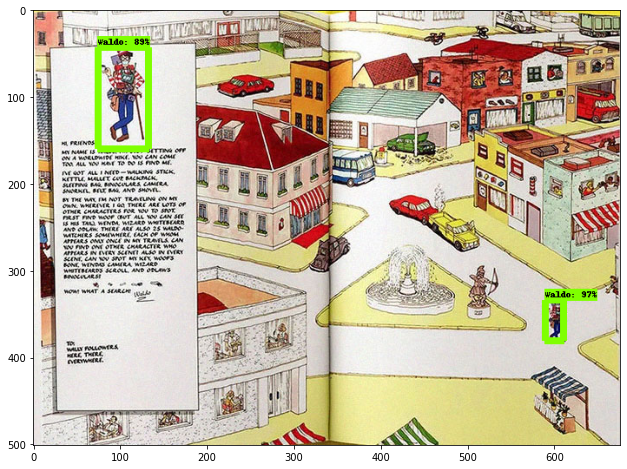

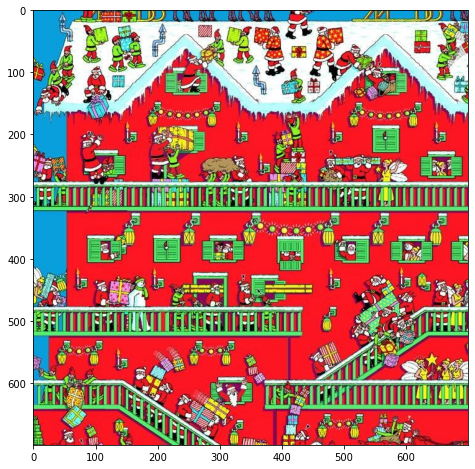

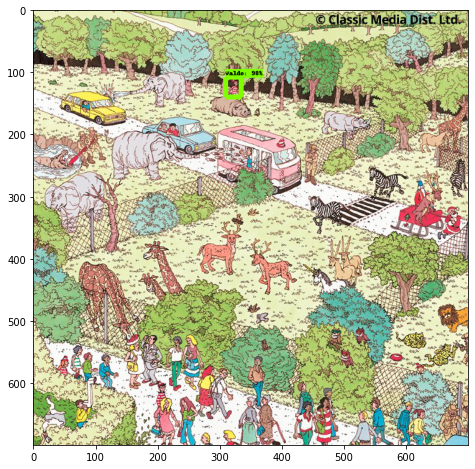

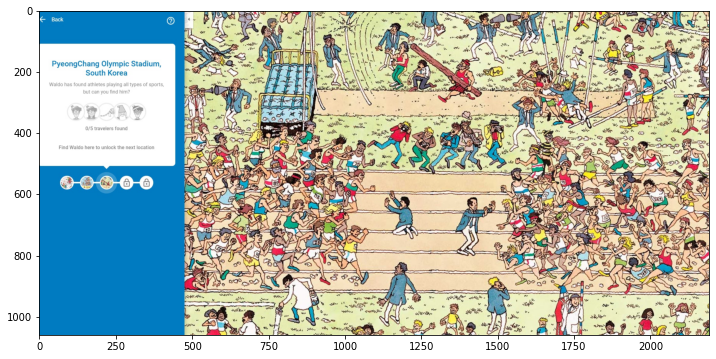

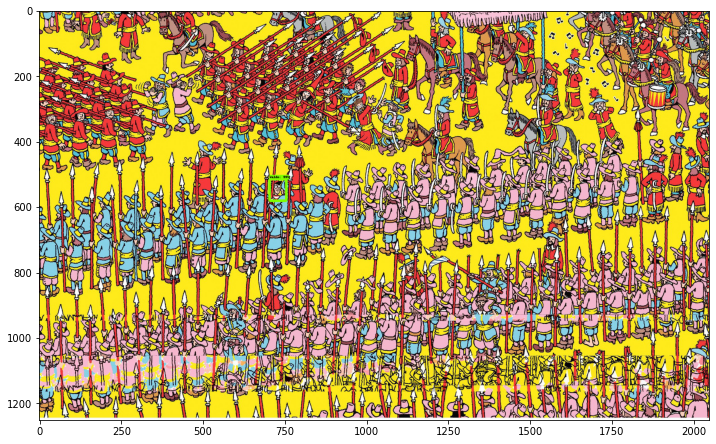

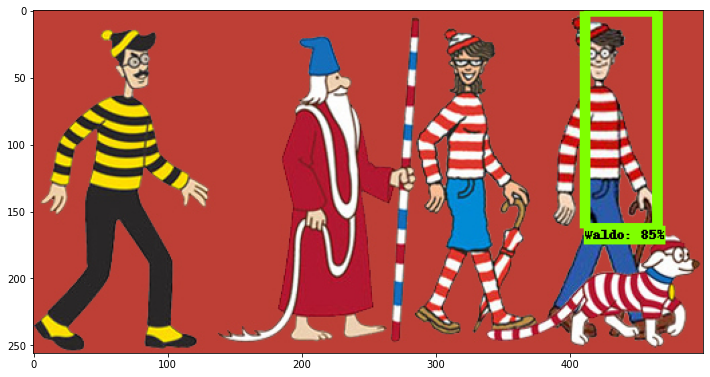

In [14]:
%cd object_detection


import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

num_classes = get_num_classes(label_map_pbtxt_fname)

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)